In [1]:
import os
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image

## Convert image to jpg

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
images_dir = './images_dataset'
images_path = [os.path.join(images_dir, image_name) for image_name in  os.listdir(images_dir)]

In [3]:
for image in images_path :
    if not image.endswith('jpg') :
        im = Image.open(image)
        rgb_im = im.convert("RGB")
        image_name = image[:-4]
        rgb_im.save(f"{image_name}.jpg")

In [24]:
# 64x64 -> 129x129
input_transforms = transforms.Compose([transforms.Resize((64,64))])
output_transforms = transforms.Compose([transforms.Resize((129, 129))])
input = torchvision.io.read_image(images_path[20]).type(torch.float32) / 255.
input_transformed = input_transforms(input)
output_transformed = output_transforms(input)
input_transformed.shape, output_transformed.shape

(torch.Size([3, 64, 64]), torch.Size([3, 129, 129]))

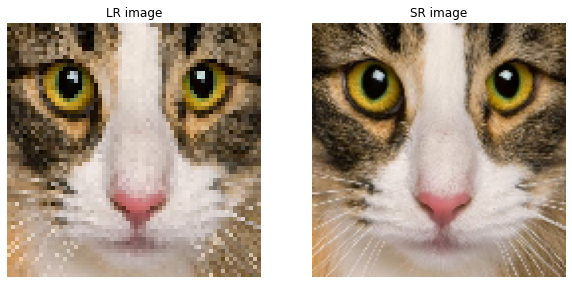

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(input_transformed.permute((1,2,0)))
plt.title('LR image')
plt.axis('off');
plt.subplot(1,2,2)
plt.title('SR image')
plt.imshow(output_transformed.permute((1,2,0)))
plt.axis('off');

## Image to Tensor

In [42]:
def toTensor(images_path , to_size = (64,129)):
    full_tensor = []
    input_transformer = transforms.Compose([transforms.Resize((to_size[0], to_size[0]))])
    output_transformer = transforms.Compose([transforms.Resize((to_size[1], to_size[1]))])
    for image in images_path :
        image = torchvision.io.read_image(image).type(torch.float32) / 255.
        input_ = input_transformer(image)
        output_ = output_transformer(image)
        full_tensor.append((input_, output_))

    return full_tensor

In [51]:
# 64x64 -> 129x129
train_data = toTensor(images_path, to_size=(64,129))
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

In [91]:
_input, _output = next(iter(train_dataloader))
_input.shape, _output.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8, 3, 129, 129]))

## TrainStep

In [95]:
def train_step(model, dataloader, loss_fn, optimizer) :
    model.train()
    train_loss = 0 

    for batch, (x,y) in enumerate(dataloader) :
        x, y = x.to(device), y.to(device)

        #forward pass
        y_pred = model(x) # same as model.forward(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        
        #update weight and bias
        loss.backward()
        optimizer.step()

    # adjust to take avg for each batch
    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    model.eval() 
    test_loss = 0
    
    # Turn on inference context manager
    with torch.inference_mode():

        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    return test_loss

In [99]:
from tqdm.auto import tqdm
from torch import nn

def train_model(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.MSELoss(),
          scheduler = None ,
          epochs: int = 5) :
    
    best_loss = np.Infinity
    results = {"train_loss": [],
    }

    for epoch in tqdm(range(epochs)) :
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer)
        scheduler.step(train_loss)

        if  train_loss < best_loss: 
            best_loss = train_loss
            model_name = f'model_mae_{train_loss:.4f}.pth'
            torch.save(model.state_dict(), f'./model_checkpoint/{model_name}')
            print(f' -- save model to ./model_checkpoint/{model_name} with loss {train_loss:.4f}')
    
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
        )

        #Update results dictionary
        results["train_loss"].append(train_loss)
    
    return results

In [102]:
from model import SRCNN 

model = SRCNN(in_channels=3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.09, patience=10)
train_model(model, train_dataloader, optimizer, loss_fn, scheduler, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

 -- save model to ./model_checkpoint/model_mae_0.3034.pth with loss 0.3034
Epoch: 1 | train_loss: 0.3034 | 
 -- save model to ./model_checkpoint/model_mae_0.1188.pth with loss 0.1188
Epoch: 2 | train_loss: 0.1188 | 
 -- save model to ./model_checkpoint/model_mae_0.0542.pth with loss 0.0542
Epoch: 3 | train_loss: 0.0542 | 
 -- save model to ./model_checkpoint/model_mae_0.0524.pth with loss 0.0524
Epoch: 4 | train_loss: 0.0524 | 
 -- save model to ./model_checkpoint/model_mae_0.0461.pth with loss 0.0461
Epoch: 5 | train_loss: 0.0461 | 


{'train_loss': [0.3034045199553172,
  0.11882932525542048,
  0.054220988932583064,
  0.05244802435239156,
  0.04613204010658794]}